# Perfect Model Experiments: Arctic Sea ice 
  
Katie Brennan  
July 2020 
  
Experiments drawing observations from the CCSM4 last millennium run at the proxy locations of the Pages2kv2 dataset. They were then assimilated into a 200 member prior ensemble drawn from the CCSM4 last millennium run to test this techniqe in a perfect model environment. 

### Sensitivity to uncertainty in the proxies (R): 
I tested various different values of R: 
* R = 0.01, 0.1, 0.4 for all proxy locations
* R = the value used for the Pages2kv2 dataset
  
**Using the error from the Pages2kv2 dataset led to the best performance in total Arctic sea ice extent (Correlation = 0.73, CE = 0.54)**, but the results were very similar the experiments that used R=0.1 everywhere (Correlation = 0.72, CE = 0.51). 

In [2]:
import sys,os,copy

In [3]:
import sys
import numpy as np
import pickle

from scipy import stats
from scipy import signal

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

In [4]:
sys.path.insert(1,'/home/disk/p/mkb22/Documents/si_analysis_kb/instrumental_assimilation_experiments/')
import reanalysis_recons_utils as rrutils

sys.path.insert(1,'/home/disk/kalman2/mkb22/LMR_lite/')
import LMR_utils 

sys.path.insert(1,'/home/disk/p/mkb22/Documents/si_utils_kb/')
import Sice_utils as siutils 
import stats_utils as kbstats

sys.path.insert(1,'/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/')
import commonera_utils as ce_utils 

Loading information from datasets.yml
Loading information from grid_def.yml
Loading information from datasets.yml
Loading information from grid_def.yml


In [5]:
import importlib
# #importlib.reload(LMRlite)
# #importlib.reload(LMR_config)
# importlib.reload(LMRlite)
importlib.reload(ce_utils)

<module 'commonera_utils' from '/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/commonera_utils.py'>

In [6]:
plt.rcParams['figure.dpi']=200

In [7]:
def load_ccsm4_lm_regridded():
    ccsm4_dir = '/home/disk/chaos/mkb22/Documents/SeaIceData/CCSM4/CCSM4_last_millennium/'
    ccsm4_file = 'ccsm4_sic_tas_20CRv2_850_1850_full.npz'

    ccsm4_lm = np.load(ccsm4_dir+ccsm4_file)

    ccsm4_truth_sic = ccsm4_lm['sic_ccsm4']
    ccsm4_truth_tas = ccsm4_lm['tas_ccsm4']
    ccsm4_truth_lat = ccsm4_lm['lat_ccsm4']
    ccsm4_truth_lon = ccsm4_lm['lon_ccsm4']
    
    return ccsm4_truth_tas, ccsm4_truth_sic, ccsm4_truth_lat, ccsm4_truth_lon

In [8]:
def calc_ccsm4_lm_tot_si(ccsm4_truth_sic,ccsm4_truth_lat, ccsm4_truth_time,anom_start, anom_end):
    # NH surface area in M km^2 from concentration in percentage
    nharea = 2*np.pi*(6380**2)/1e8

    sie_lalo_ccsm4 = siutils.calc_sea_ice_extent(ccsm4_truth_sic,15.0)

    _,nh_sic_truth,_ = LMR_utils.global_hemispheric_means(ccsm4_truth_sic,ccsm4_truth_lat[:,0])
    _,nh_sie_truth,_ = LMR_utils.global_hemispheric_means(sie_lalo_ccsm4,ccsm4_truth_lat[:,0])
    sia_ccsm4_truth = nh_sic_truth*nharea
    sie_ccsm4_truth = nh_sie_truth*nharea
    
    anom_int = np.where((ccsm4_truth_time>=anom_start)&(ccsm4_truth_time<anom_end+1))

    sia_ccsm4_truth_anom = sia_ccsm4_truth - np.nanmean(sia_ccsm4_truth[anom_int])
    sie_ccsm4_truth_anom = sie_ccsm4_truth - np.nanmean(sie_ccsm4_truth[anom_int])
    
    return sia_ccsm4_truth, sie_ccsm4_truth, sia_ccsm4_truth_anom, sie_ccsm4_truth_anom

In [9]:
def sub_arctic_plot(fig,ax,VAR1,LAT,LON,TITLE1,MAX1):
    var1, lon1 = add_cyclic_point(VAR1, coord=LON)
    new_lon2d, new_lat2d = np.meshgrid(lon1, LAT)
    
    ax.set_extent([-150, 140, 50, 90], crs=ccrs.PlateCarree())
    ax.gridlines(linestyle='--')
    ax.add_feature(cfeature.LAND, facecolor=(1, 1, 1))
    cs = ax.pcolormesh(new_lon2d, new_lat2d, var1, 
                       vmin=-MAX1, vmax=MAX1, cmap=plt.cm.RdBu_r, 
                       transform=ccrs.PlateCarree())
    ax.coastlines(resolution='110m', linewidth=0.5)
#    plt.colorbar(cs, ax=ax)
    ax.set_title(TITLE1)
    
    return cs

In [10]:
proj = dict(projection=ccrs.Stereographic(central_latitude=90,
                                          central_longitude=-45,
                                          true_scale_latitude=0.1))

In [11]:
# output_dir_ccsm4 = '/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/experiments/pseudo/'
# output_file_ccsm4 = 'sic_ccsm4_anrecon_1400_1850_pseudo_inf1_loc15000_R0_1_iter0.pkl'

# niter = 8

# [sic_lalo_allit_ccsm4, tas_lalo_allit_ccsm4, sic_ens_var_allit_ccsm4, 
#  nobs_allit_ccsm4, sia_ens_allit_ccsm4, sie_ens_allit_ccsm4, 
#  Ye_assim_allit_ccsm4, Ye_assim_coords_allit_ccsm4, 
#  Xb_inflate_allit_ccsm4, recon_years] = ce_utils.load_recon_allit(output_dir_ccsm4,
#                                                                   output_file_ccsm4,
#                                                                   niter, prox_loc=False)

### Load Last Millennium 'truth' simulation: 

In [12]:
[ccsm4_truth_tas, ccsm4_truth_sic, 
 ccsm4_truth_lat, ccsm4_truth_lon] = load_ccsm4_lm_regridded()

ccsm4_truth_time = np.arange(850,1851,1)

[sia_ccsm4_truth, sie_ccsm4_truth, 
 sia_ccsm4_truth_anom, sie_ccsm4_truth_anom] = calc_ccsm4_lm_tot_si(ccsm4_truth_sic,ccsm4_truth_lat, 
                                                                    ccsm4_truth_time, 1400, 1849)

In [13]:
[mpi_truth_tas, mpi_truth_sic, 
 mpi_truth_lat, mpi_truth_lon] = ce_utils.load_mpi_lm_regridded()

mpi_time = np.arange(850,1850,1)

[sia_mpi, sie_mpi, sia_mpi_anom, 
 sie_mpi_anom,_,_,_,_] = ce_utils.calc_lm_tot_si(mpi_truth_sic,mpi_truth_lat, 
                                                       mpi_time, 1400, 1849)

In [14]:
it_truth = np.where(ccsm4_truth_time>=1400)
it_mpi = np.where(mpi_time>=1400)
 
sia_ccsm4_truth_anom = sia_ccsm4_truth_anom[it_truth]
sie_ccsm4_truth_anom = sie_ccsm4_truth_anom[it_truth]

sia_mpi_anom = sia_mpi_anom[it_mpi]
sie_mpi_anom = sie_mpi_anom[it_mpi]

### Load pseudo experiments, R = 0.1: 

In [24]:
output_dir_ccsm4 = '/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/experiments/pseudo/'
output_file_ccsm4 = 'sic_ccsm4_anrecon_1400_1850_pseudo_inf1_loc15000_R0_1_iter0.pkl'

niter = 10

[sic_lalo_allit, tas_lalo_allit, sic_ens_var_allit, 
 nobs_allit, obs_loc_allit, sia_Nens_allit, sie_Nens_allit, 
 sia_Sens_allit, sie_Sens_allit, Xb_inflate_allit, prox_lat, prox_lon, 
 recon_years, tas_truth_allit] = ce_utils.load_pseudo_recon_allit(output_dir_ccsm4,
                                                                  output_file_ccsm4,niter)

In [25]:
nharea = 2*np.pi*(6380**2)/1e8

sie_ccsm4_recon = np.nanmean(np.nanmean(sie_Nens_allit,axis=1),axis=1)*nharea
sie_ccsm4_recon_anom = sie_ccsm4_recon - np.nanmean(sie_ccsm4_recon)

sie_Nens_allit_2d = np.reshape(sie_Nens_allit*nharea,
                               (sie_Nens_allit.shape[0],
                                sie_Nens_allit.shape[1]*sie_Nens_allit.shape[2]))
sie_recon_97_5 = np.percentile(sie_Nens_allit_2d,97.5,axis=1)
sie_recon_2_5 = np.percentile(sie_Nens_allit_2d,2.5,axis=1)

sie_recon_97_5_anom = sie_recon_97_5 - np.nanmean(sie_recon_97_5)
sie_recon_2_5_anom = sie_recon_2_5 - np.nanmean(sie_recon_2_5)

### Plot results: 

In [26]:
[ce_sie_pseudo,
 corr_sie_pseudo,_,_] = rrutils.find_ce_corr(sie_ccsm4_truth_anom, 
                                                   sie_ccsm4_recon_anom,
                                                   np.array(recon_years),
                                                   ccsm4_truth_time[it_truth],
                                                   1400,1849)

corr_sie_pseudo,ce_sie_pseudo

(0.7218987947471487, 0.5195662821124245)

In [27]:
[ce_sie_pseudo_late,
 corr_sie_pseudo_late,_,_] = rrutils.find_ce_corr(sie_ccsm4_truth_anom, 
                                                   sie_ccsm4_recon_anom,
                                                   np.array(recon_years),
                                                   ccsm4_truth_time[it_truth],
                                                   1600,1849)

corr_sie_pseudo_late,ce_sie_pseudo_late

(0.7575446655898114, 0.5512309902750162)

In [28]:
[ce_sie_mod,
 corr_sie_mod,_,_] = rrutils.find_ce_corr(sie_ccsm4_truth_anom, 
                                          sie_mpi_anom,
                                          mpi_time[it_mpi],
                                          ccsm4_truth_time[it_truth],
                                          1400,1849)

corr_sie_mod,ce_sie_mod

(0.16344232288289065, -0.6460765581672023)

(1390, 1860)

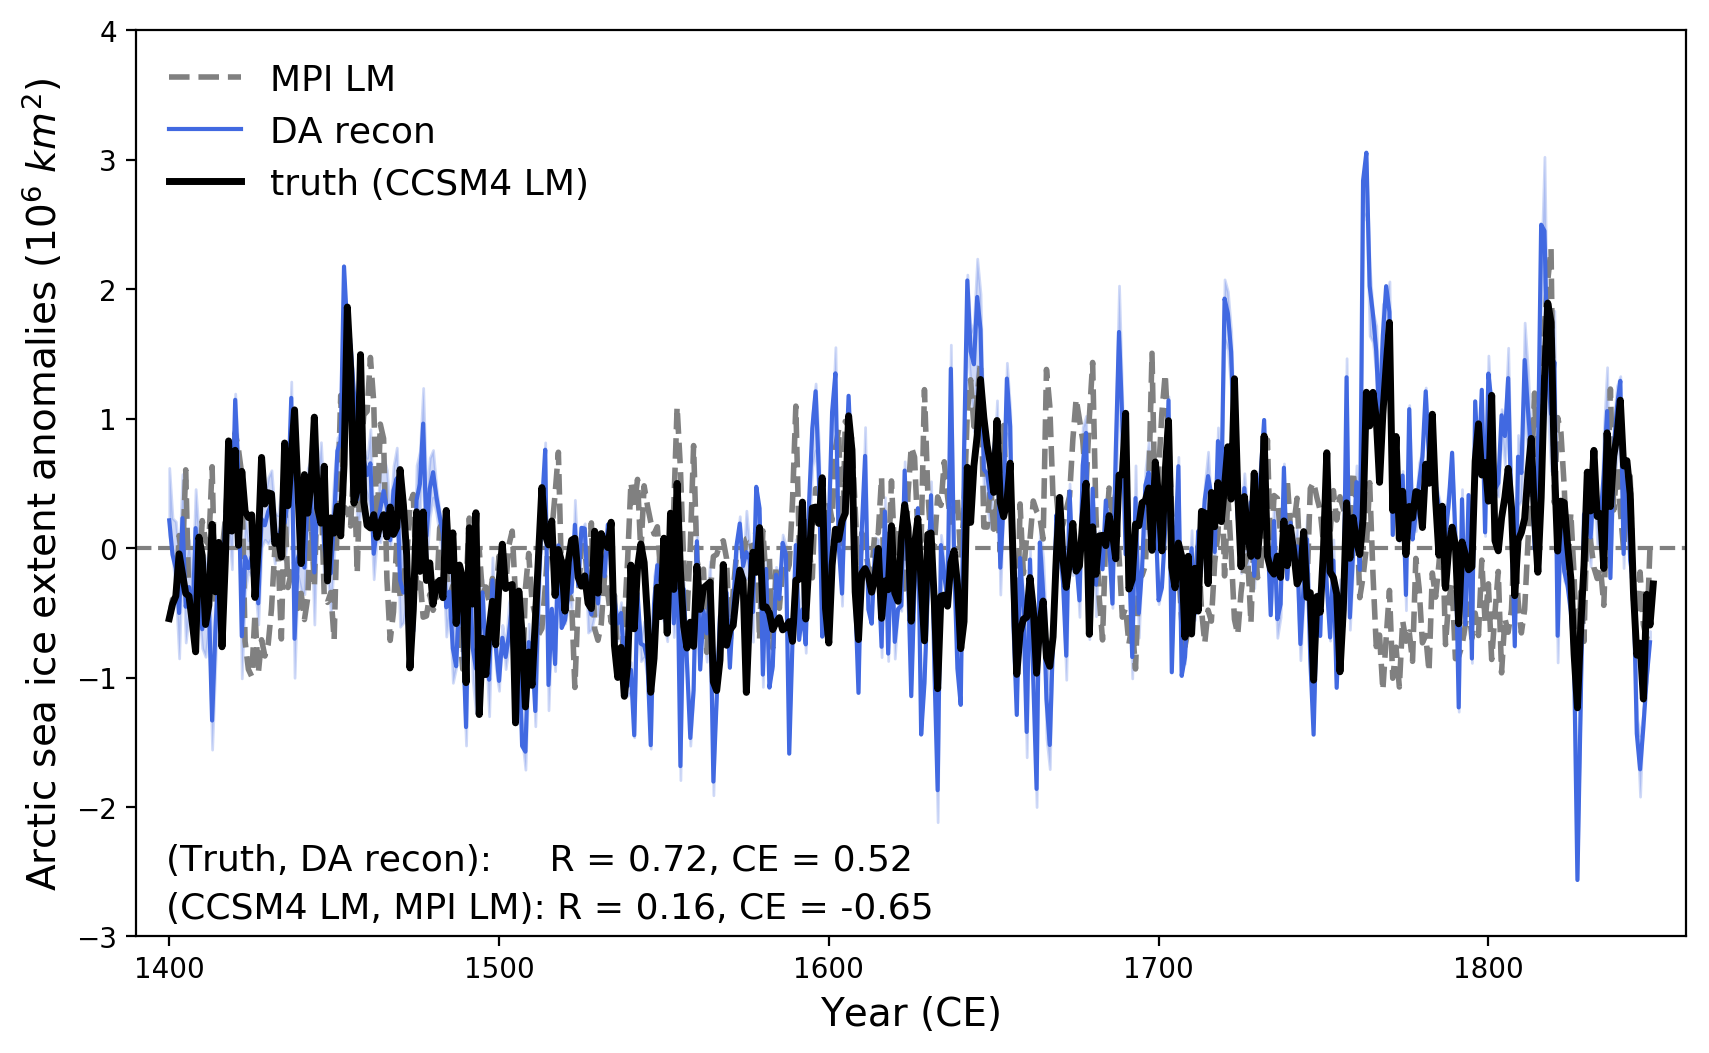

In [29]:
plt.figure(figsize=(10,6))
plt.axhline(0,linestyle='--',color='grey')

plt.plot(mpi_time[it_mpi],sie_mpi_anom, label='MPI LM',
         color='gray',linewidth=2, linestyle ='--')
plt.plot(recon_years,sie_ccsm4_recon_anom, label = 'DA recon',
         color='royalblue',linewidth=1.5)
plt.plot(ccsm4_truth_time[it_truth],sie_ccsm4_truth_anom, label='truth (CCSM4 LM)',
         color='k',linewidth=2.5)

plt.fill_between(recon_years,sie_recon_2_5_anom,sie_recon_97_5_anom,
                 color='royalblue',alpha=0.25)

plt.ylabel('Arctic sea ice extent anomalies (10$^{6}$ $km^2$)',fontsize=14)
plt.xlabel('Year (CE)',fontsize=14)
#plt.title('Total Arctic Sea Ice Extent', fontsize=14)

plt.legend(fontsize=13,loc='upper left',frameon=False)#,bbox_to_anchor=(0.81, 0.22),frameon=False)
plt.ylim(-3,4,1)
ce_corr_plt_ccsm4 = (('(Truth, DA recon):     R = ' + 
                      '{:,.2f}'.format(corr_sie_pseudo))+
                     ', CE = '+'{:,.2f}'.format(ce_sie_pseudo))
ce_corr_plt_mod = (('(CCSM4 LM, MPI LM): R = ' + 
                      '{:,.2f}'.format(corr_sie_mod))+
                     ', CE = '+'{:,.2f}'.format(ce_sie_mod))

plt.gcf().text(0.14, 0.14, ce_corr_plt_mod , fontsize=13,color='k')
plt.gcf().text(0.14, 0.18, ce_corr_plt_ccsm4 , fontsize=13,color='k')

plt.xlim(1390,1860)

Text(0,0.5,'Number of proxies assimilated')

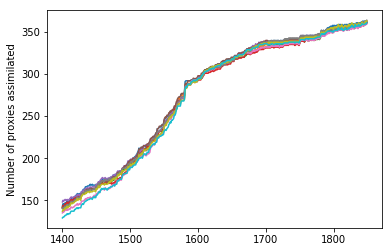

In [22]:
plt.plot(recon_years, nobs_allit)
plt.ylabel('Number of proxies assimilated')

### Load pseudo experiments, R = 0.4: 

In [25]:
output_dir_ccsm4 = '/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/experiments/pseudo/'
output_file_ccsm4 = 'sic_ccsm4_anrecon_1400_1850_pseudo_inf1_loc15000_R0_4_iter0.pkl'
niter = 10

[sic_lalo_allit, tas_lalo_allit, sic_ens_var_allit, 
 nobs_allit, obs_loc_allit, sia_Nens_allit, sie_Nens_allit, 
 sia_Sens_allit, sie_Sens_allit, Xb_inflate_allit, prox_lat, prox_lon, 
 recon_years, tas_truth_allit] = ce_utils.load_pseudo_recon_allit(output_dir_ccsm4,
                                                                  output_file_ccsm4,niter)

In [26]:
nharea = 2*np.pi*(6380**2)/1e8

sie_ccsm4_recon = np.nanmean(np.nanmean(sie_Nens_allit,axis=1),axis=1)*nharea
sie_ccsm4_recon_anom = sie_ccsm4_recon - np.nanmean(sie_ccsm4_recon)

sie_Nens_allit_2d = np.reshape(sie_Nens_allit*nharea,
                               (sie_Nens_allit.shape[0],
                                sie_Nens_allit.shape[1]*sie_Nens_allit.shape[2]))
sie_recon_97_5 = np.percentile(sie_Nens_allit_2d,97.5,axis=1)
sie_recon_2_5 = np.percentile(sie_Nens_allit_2d,2.5,axis=1)

sie_recon_97_5_anom = sie_recon_97_5 - np.nanmean(sie_recon_97_5)
sie_recon_2_5_anom = sie_recon_2_5 - np.nanmean(sie_recon_2_5)

In [27]:
[ce_sie_pseudo,
 corr_sie_pseudo,_,_] = rrutils.find_ce_corr(sie_ccsm4_truth_anom, 
                                                   sie_ccsm4_recon_anom,
                                                   np.array(recon_years),
                                                   ccsm4_truth_time[it_truth],
                                                   1400,1849)

corr_sie_pseudo,ce_sie_pseudo

(0.6833815182450481, 0.4630482301104881)

(1390, 1860)

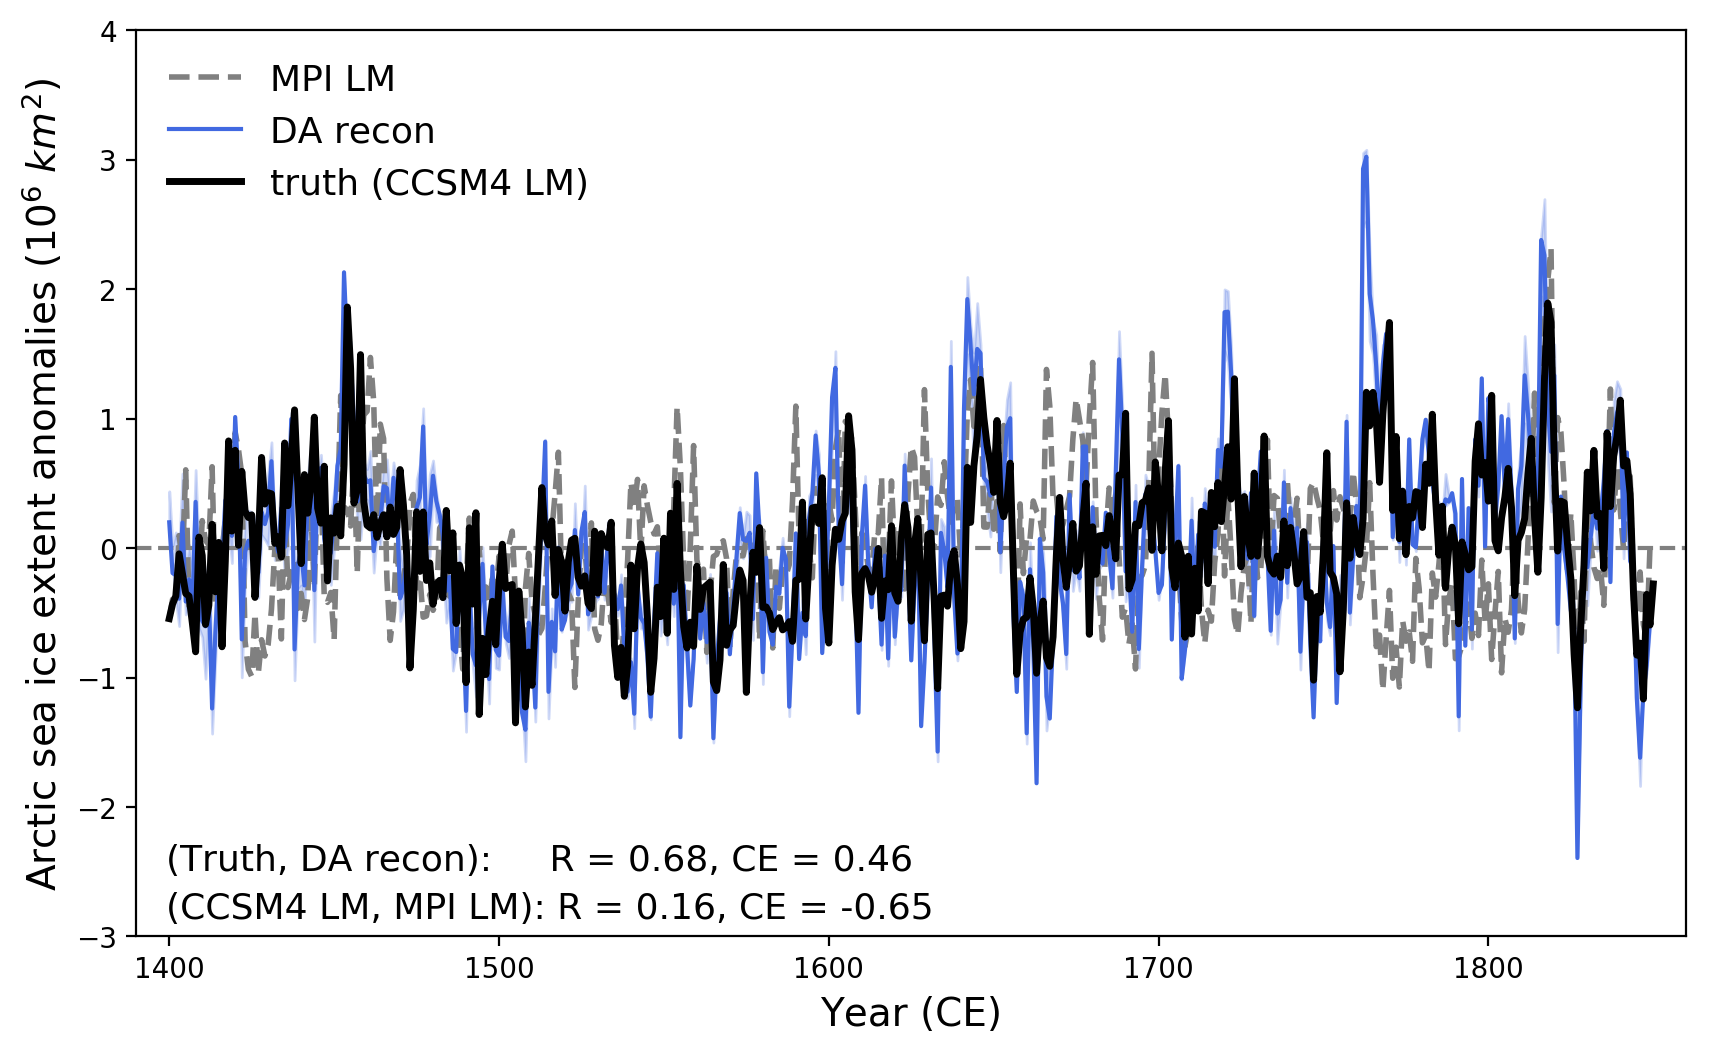

In [28]:
plt.figure(figsize=(10,6))
plt.axhline(0,linestyle='--',color='grey')

plt.plot(mpi_time[it_mpi],sie_mpi_anom, label='MPI LM',
         color='gray',linewidth=2, linestyle ='--')
plt.plot(recon_years,sie_ccsm4_recon_anom, label = 'DA recon',
         color='royalblue',linewidth=1.5)
plt.plot(ccsm4_truth_time[it_truth],sie_ccsm4_truth_anom, label='truth (CCSM4 LM)',
         color='k',linewidth=2.5)

plt.fill_between(recon_years,sie_recon_2_5_anom,sie_recon_97_5_anom,
                 color='royalblue',alpha=0.25)

plt.ylabel('Arctic sea ice extent anomalies (10$^{6}$ $km^2$)',fontsize=14)
plt.xlabel('Year (CE)',fontsize=14)
#plt.title('Total Arctic Sea Ice Extent', fontsize=14)

plt.legend(fontsize=13,loc='upper left',frameon=False)#,bbox_to_anchor=(0.81, 0.22),frameon=False)
plt.ylim(-3,4,1)
ce_corr_plt_ccsm4 = (('(Truth, DA recon):     R = ' + 
                      '{:,.2f}'.format(corr_sie_pseudo))+
                     ', CE = '+'{:,.2f}'.format(ce_sie_pseudo))
ce_corr_plt_mod = (('(CCSM4 LM, MPI LM): R = ' + 
                      '{:,.2f}'.format(corr_sie_mod))+
                     ', CE = '+'{:,.2f}'.format(ce_sie_mod))

plt.gcf().text(0.14, 0.14, ce_corr_plt_mod , fontsize=13,color='k')
plt.gcf().text(0.14, 0.18, ce_corr_plt_ccsm4 , fontsize=13,color='k')

plt.xlim(1390,1860)

Text(0,0.5,'Number of proxies assimilated')

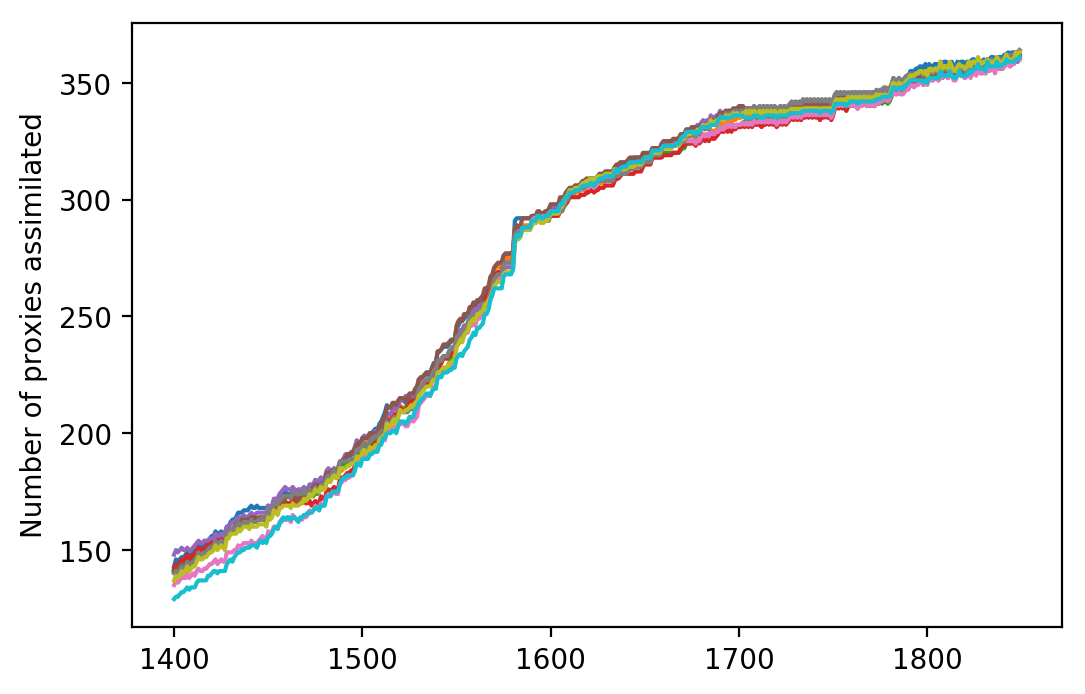

In [ ]:
plt.plot(recon_years, nobs_allit)
plt.ylabel('Number of proxies assimilated')

### Load psedo experiments, R = Pages2kv2 values: 

In [15]:
output_dir_ccsm4 = '/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/experiments/pseudo/'
output_file_ccsm4 = 'sic_ccsm4_anrecon_1400_1850_pseudo_inf1_loc15000_Rpages2kv2_iter0.pkl'
niter = 10

[sic_lalo_allit, tas_lalo_allit, sic_ens_var_allit, 
 nobs_allit, obs_loc_allit, sia_Nens_allit, sie_Nens_allit, 
 sia_Sens_allit, sie_Sens_allit, Xb_inflate_allit, prox_lat, prox_lon, 
 recon_years, tas_truth_allit] = ce_utils.load_pseudo_recon_allit(output_dir_ccsm4,
                                                                  output_file_ccsm4,niter)

In [16]:
nharea = 2*np.pi*(6380**2)/1e8

sie_ccsm4_recon = np.nanmean(np.nanmean(sie_Nens_allit,axis=1),axis=1)*nharea
sie_ccsm4_recon_anom = sie_ccsm4_recon - np.nanmean(sie_ccsm4_recon)

sie_Nens_allit_2d = np.reshape(sie_Nens_allit*nharea,
                               (sie_Nens_allit.shape[0],
                                sie_Nens_allit.shape[1]*sie_Nens_allit.shape[2]))
sie_recon_97_5 = np.percentile(sie_Nens_allit_2d,97.5,axis=1)
sie_recon_2_5 = np.percentile(sie_Nens_allit_2d,2.5,axis=1)

sie_recon_97_5_anom = sie_recon_97_5 - np.nanmean(sie_recon_97_5)
sie_recon_2_5_anom = sie_recon_2_5 - np.nanmean(sie_recon_2_5)

In [17]:
[ce_sie_pseudo,
 corr_sie_pseudo,_,_] = rrutils.find_ce_corr(sie_ccsm4_truth_anom, 
                                             sie_ccsm4_recon_anom,
                                             np.array(recon_years),
                                             ccsm4_truth_time[it_truth],
                                             1400,1849)

corr_sie_pseudo,ce_sie_pseudo

(0.7346655510791604, 0.5386695713934395)

In [18]:
np.std(sie_ccsm4_truth_anom), np.std(sie_ccsm4_recon_anom)

(0.5495158562690651, 0.7833822654276653)

In [19]:
613687773786.5809/1e11

6.1368777378658095

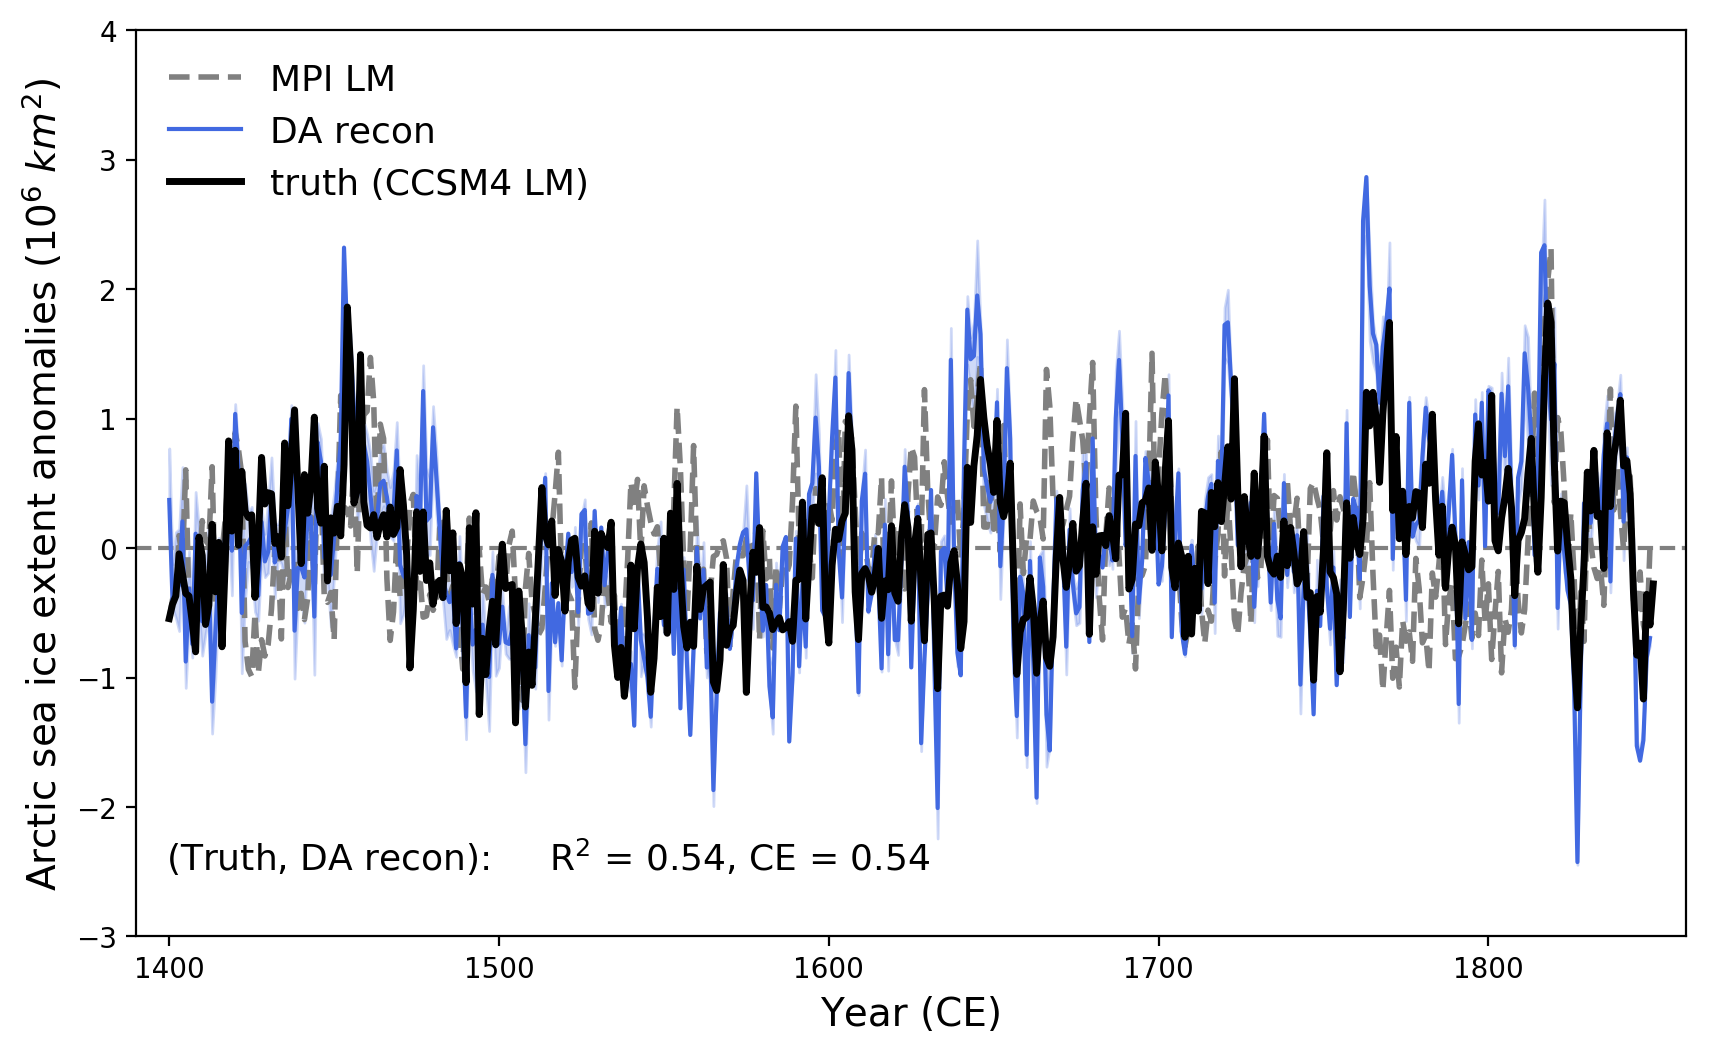

In [22]:
plt.figure(figsize=(10,6))
plt.axhline(0,linestyle='--',color='grey')

plt.plot(mpi_time[it_mpi],sie_mpi_anom, label='MPI LM',
         color='gray',linewidth=2, linestyle ='--')
plt.plot(recon_years,sie_ccsm4_recon_anom, label = 'DA recon',
         color='royalblue',linewidth=1.5)
plt.plot(ccsm4_truth_time[it_truth],sie_ccsm4_truth_anom, label='truth (CCSM4 LM)',
         color='k',linewidth=2.5)

plt.fill_between(recon_years,sie_recon_2_5_anom,sie_recon_97_5_anom,
                 color='royalblue',alpha=0.25)

plt.ylabel('Arctic sea ice extent anomalies (10$^{6}$ $km^2$)',fontsize=14)
plt.xlabel('Year (CE)',fontsize=14)
#plt.title('Total Arctic Sea Ice Extent', fontsize=14)

plt.legend(fontsize=13,loc='upper left',frameon=False)#,bbox_to_anchor=(0.81, 0.22),frameon=False)
plt.ylim(-3,4,1)
ce_corr_plt_ccsm4 = (('(Truth, DA recon):     R$^2$ = ' + 
                      '{:,.2f}'.format(corr_sie_pseudo**2))+
                     ', CE = '+'{:,.2f}'.format(ce_sie_pseudo))
# ce_corr_plt_mod = (('(CCSM4 LM, MPI LM): R$^2$ = ' + 
#                       '{:,.2f}'.format(corr_sie_mod**2))+
#                      ', CE = '+'{:,.2f}'.format(ce_sie_mod))

#plt.gcf().text(0.14, 0.14, ce_corr_plt_mod , fontsize=13,color='k')
plt.gcf().text(0.14, 0.18, ce_corr_plt_ccsm4 , fontsize=13,color='k')

plt.xlim(1390,1860)

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'Pseudo_arctic_sie_timeseries_performance_recon_truth.png'
#plt.savefig(savedir+savename)

In [ ]:
plt.plot(recon_years, nobs_allit)
plt.ylabel('Number of proxies assimilated')

In [23]:
nharea = 2*np.pi*(6380**2)/1e8

sie_ccsm4_recon = np.nanmean(np.nanmean(sie_Sens_allit,axis=1),axis=1)*nharea
sie_ccsm4_recon_anom = sie_ccsm4_recon - np.nanmean(sie_ccsm4_recon)

sie_Sens_allit_2d = np.reshape(sie_Sens_allit*nharea,
                               (sie_Sens_allit.shape[0],
                                sie_Sens_allit.shape[1]*sie_Sens_allit.shape[2]))
sie_recon_97_5 = np.percentile(sie_Sens_allit_2d,97.5,axis=1)
sie_recon_2_5 = np.percentile(sie_Sens_allit_2d,2.5,axis=1)

sie_recon_97_5_anom = sie_recon_97_5 - np.nanmean(sie_recon_97_5)
sie_recon_2_5_anom = sie_recon_2_5 - np.nanmean(sie_recon_2_5)

In [24]:
[ce_sie_pseudo,
 corr_sie_pseudo,_,_] = rrutils.find_ce_corr(sie_ccsm4_truth_anom, 
                                             sie_ccsm4_recon_anom,
                                             np.array(recon_years),
                                             ccsm4_truth_time[it_truth],
                                             1400,1849)

corr_sie_pseudo,ce_sie_pseudo

(0.15749718263668855, -2.979681271867756)

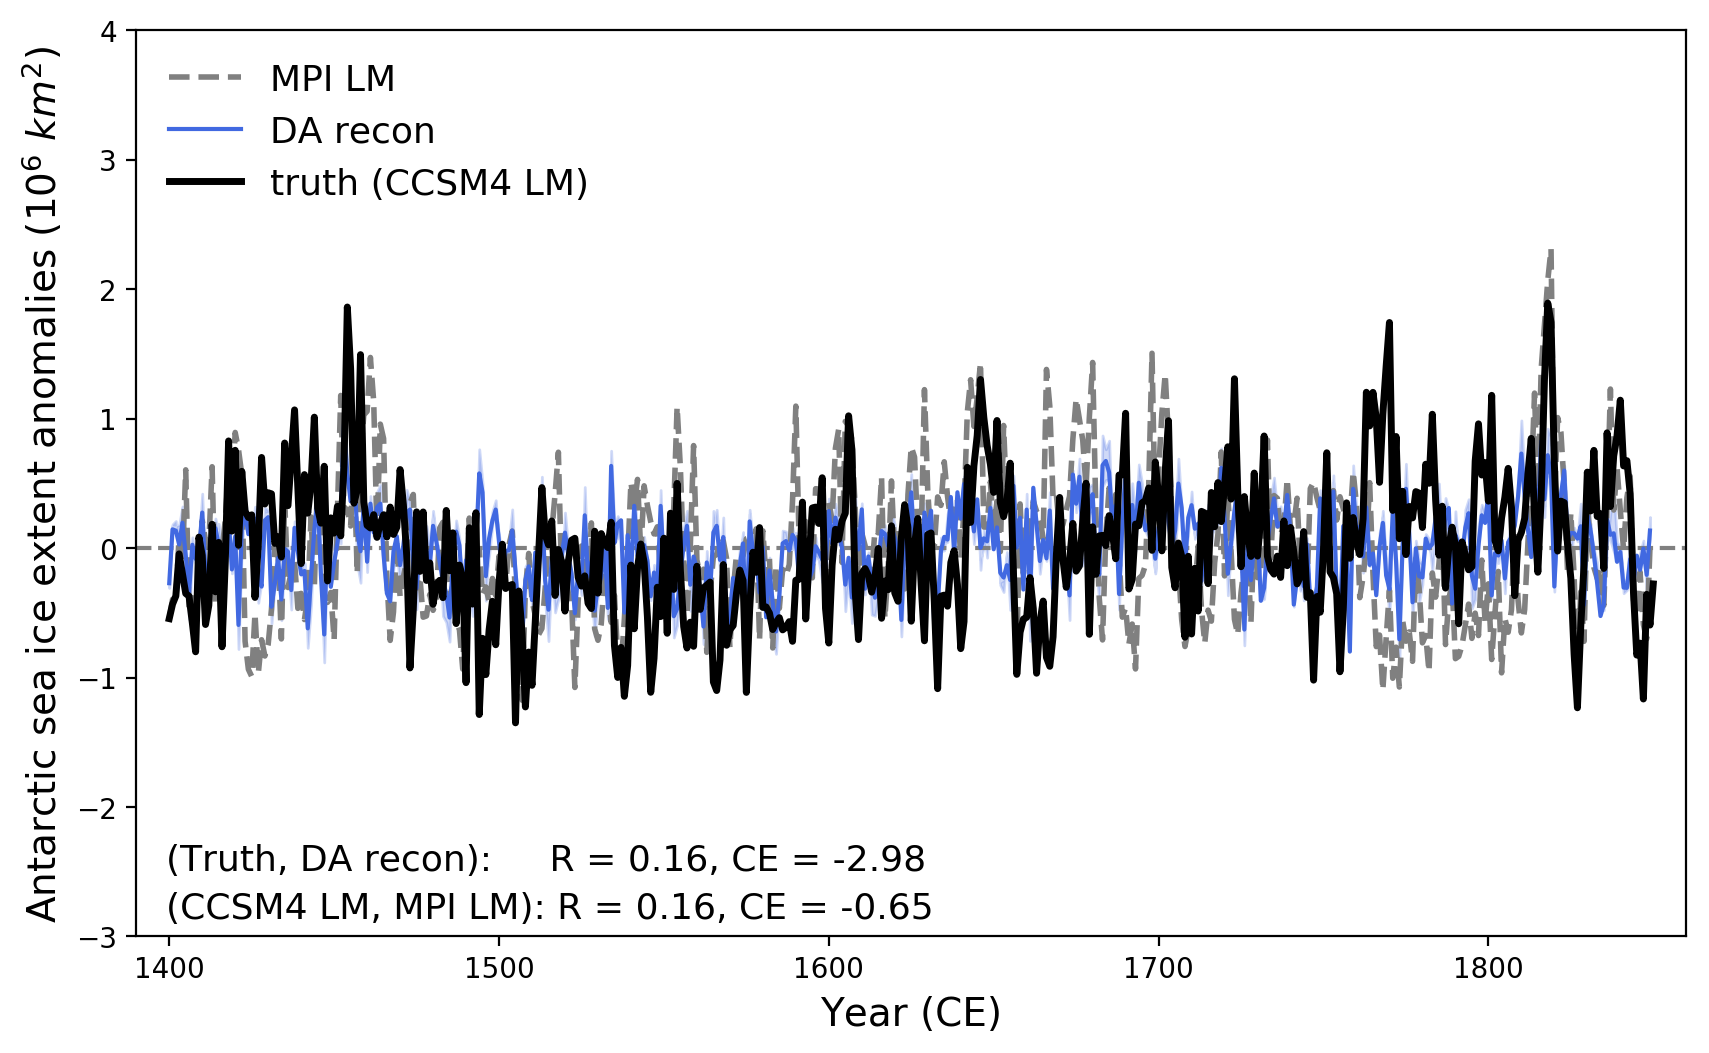

In [25]:
plt.figure(figsize=(10,6))
plt.axhline(0,linestyle='--',color='grey')

plt.plot(mpi_time[it_mpi],sie_mpi_anom, label='MPI LM',
         color='gray',linewidth=2, linestyle ='--')
plt.plot(recon_years,sie_ccsm4_recon_anom, label = 'DA recon',
         color='royalblue',linewidth=1.5)
plt.plot(ccsm4_truth_time[it_truth],sie_ccsm4_truth_anom, label='truth (CCSM4 LM)',
         color='k',linewidth=2.5)

plt.fill_between(recon_years,sie_recon_2_5_anom,sie_recon_97_5_anom,
                 color='royalblue',alpha=0.25)

plt.ylabel('Antarctic sea ice extent anomalies (10$^{6}$ $km^2$)',fontsize=14)
plt.xlabel('Year (CE)',fontsize=14)
#plt.title('Total Arctic Sea Ice Extent', fontsize=14)

plt.legend(fontsize=13,loc='upper left',frameon=False)#,bbox_to_anchor=(0.81, 0.22),frameon=False)
plt.ylim(-3,4,1)
ce_corr_plt_ccsm4 = (('(Truth, DA recon):     R = ' + 
                      '{:,.2f}'.format(corr_sie_pseudo))+
                     ', CE = '+'{:,.2f}'.format(ce_sie_pseudo))
ce_corr_plt_mod = (('(CCSM4 LM, MPI LM): R = ' + 
                      '{:,.2f}'.format(corr_sie_mod))+
                     ', CE = '+'{:,.2f}'.format(ce_sie_mod))

plt.gcf().text(0.14, 0.14, ce_corr_plt_mod , fontsize=13,color='k')
plt.gcf().text(0.14, 0.18, ce_corr_plt_ccsm4 , fontsize=13,color='k')

plt.xlim(1390,1860)

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'Pseudo_antarctic_sie_timeseries_performance_recon_truth.png'
#plt.savefig(savedir+savename)

### Spatial validation: 

In [26]:
sic_shape = sic_lalo_allit.shape
sic_shape_true = ccsm4_truth_sic.shape

sic_lalo_ensmn = np.nanmean(sic_lalo_allit,axis=3)
sic_truth_lalo = np.squeeze(ccsm4_truth_sic[it_truth,:,:])[:-1]
sic_2_5_lalo = np.percentile(sic_lalo_allit,2.5,axis=3)
sic_97_5_lalo = np.percentile(sic_lalo_allit,97.5,axis=3)

sic_prior_ensmn = np.reshape(np.nanmean(Xb_inflate_allit[91*180:],axis=2).T,(200,91,180))

sic_recon_2d = np.reshape(sic_lalo_ensmn,(sic_shape[0],sic_shape[1]*sic_shape[2]))
sic_truth_2d = np.reshape(ccsm4_truth_sic,(sic_shape_true[0],sic_shape_true[1]*sic_shape_true[2]))
sic_truth_2d = np.squeeze(sic_truth_2d[it_truth,:])[:-1]

In [27]:
r_sic = np.zeros(sic_truth_2d.shape[1])
r2_sic = np.zeros(sic_truth_2d.shape[1])
ce_sic = np.zeros(sic_truth_2d.shape[1])

for lalo in range(sic_truth_2d.shape[1]):
    r_sic[lalo],r2_sic[lalo],_ = kbstats.corr_timeseries(sic_truth_2d[:,lalo],sic_recon_2d[:,lalo])
    ce_sic[lalo]= kbstats.coefficient_efficiency(sic_truth_2d[:,lalo],sic_recon_2d[:,lalo])

/home/disk/p/mkb22/Documents/si_utils_kb/stats_utils.py:64: RuntimeWarning: invalid value encountered in double_scalars
  X_Y_corr = covariance(X,Y)/(X_stdev*Y_stdev)
/home/disk/p/mkb22/Documents/si_utils_kb/stats_utils.py:65: RuntimeWarning: invalid value encountered in double_scalars
  X_Y_reg = covariance(X,Y)/(X_stdev**2)
/home/disk/p/mkb22/Documents/si_utils_kb/stats_utils.py:177: RuntimeWarning: invalid value encountered in true_divide
  CE    = 1. - np.divide(numer,denom)
/home/disk/p/mkb22/Documents/si_utils_kb/stats_utils.py:177: RuntimeWarning: divide by zero encountered in true_divide
  CE    = 1. - np.divide(numer,denom)


In [78]:
proxinfo_loc = ('/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/'+
            'experiments/pseudo/pages2kv2_all_proxy_info.pkl')

prox_loc_info = pickle.load(open(proxinfo_loc,'rb'))

In [79]:
prox_loc_info[ptype]

{'lat': array([ 81.35  , -43.3646]),
 'lon': array([290.47  , 146.8749]),
 'color': 'royalblue',
 'label': 'Lake Core',
 'marker': '^'}

In [80]:
proxy_types = ['Tree Rings_WidthPages2', 'Tree Rings_WoodDensity', 
               'Ice Cores_d18O', 'Ice Cores_dD', 
               'Ice Cores_MeltFeature', 'Lake Cores_Varve',
               'Lake Cores_Misc']

In [81]:
# r_thresh = np.where(r_sic>np.sqrt(0.4),1.0,0.0)
# ce_thresh = np.where(ce_sic>np.sqrt(0.4),1.0,0.0)
# ax[0].contourf(ccsm4_truth_lon[0,:], ccsm4_truth_lat[:,0], r_thresh, 
#                   levels = [0,0.5,1],hatches=['','...'], alpha=0,
#                   transform=ccrs.PlateCarree())
# ax[1].contourf(ccsm4_truth_lon[0,:], ccsm4_truth_lat[:,0], ce_thresh, 
#                   levels = [0,0.5,1],hatches=['','...'], alpha=0,
#                   transform=ccrs.PlateCarree())

# ax[0].scatter(obs_lon, obs_lat, facecolors='grey', s=15,
#               edgecolors='k', transform=ccrs.PlateCarree())
# ax[1].scatter(obs_lon, obs_lat, facecolors='grey',s=15,
#               edgecolors='k', transform=ccrs.PlateCarree())

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


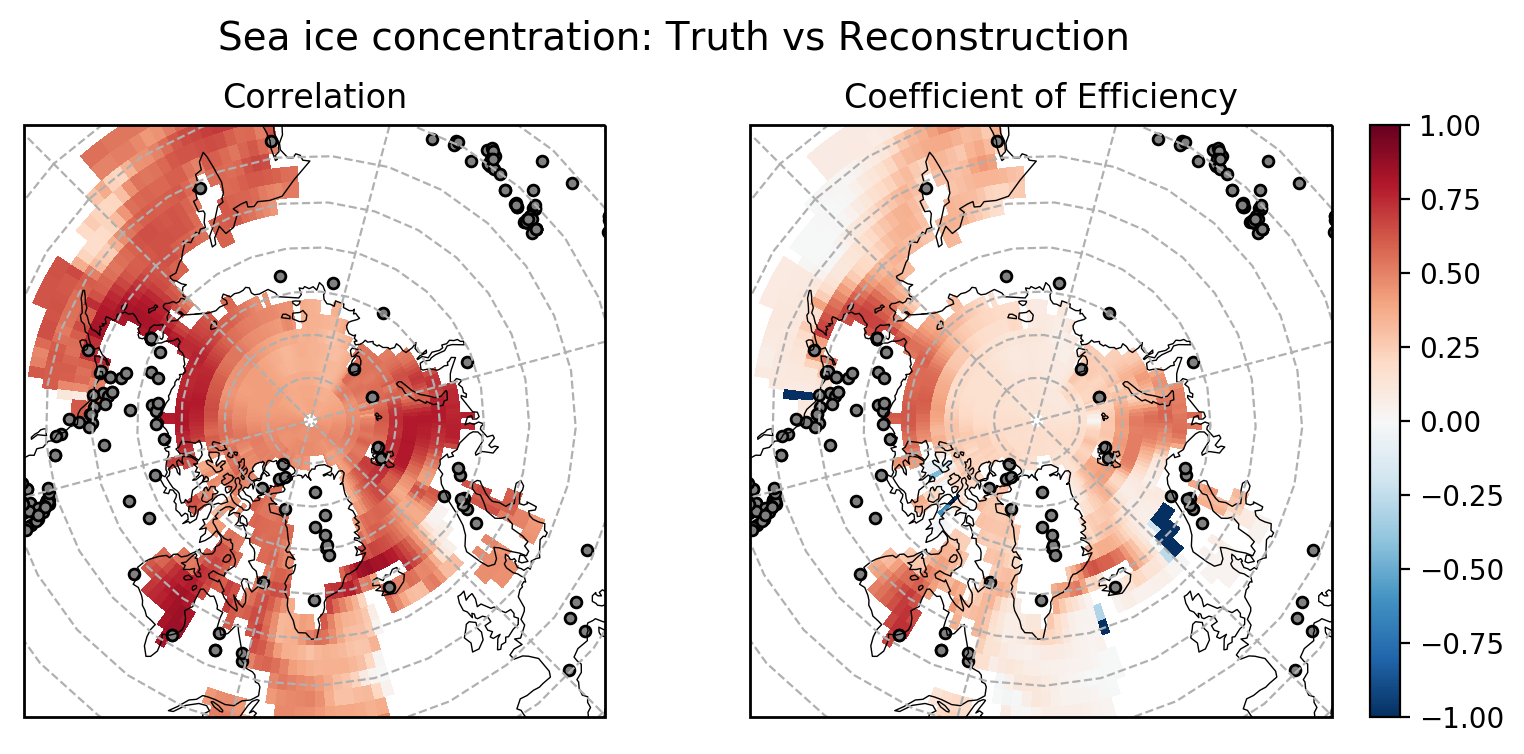

In [89]:
r_sic = np.reshape(r_sic,(sic_shape_true[1],sic_shape_true[2]))
ce_sic = np.reshape(ce_sic,(sic_shape_true[1],sic_shape_true[2]))

fig,ax = plt.subplots(1,2, figsize=(9, 4), subplot_kw = proj)

cs = sub_arctic_plot(fig,ax[0],r_sic,ccsm4_truth_lat[:,0],ccsm4_truth_lon[0,:],'Correlation',1)
cs = sub_arctic_plot(fig,ax[1],ce_sic,ccsm4_truth_lat[:,0],ccsm4_truth_lon[0,:],'Coefficient of Efficiency',1)

for ptype in proxy_types: 
    ax[0].scatter([prox_loc_info[ptype]['lon']],[prox_loc_info[ptype]['lat']],
                   color='grey',transform=ccrs.PlateCarree(), 
                   label=prox_loc_info[ptype]['label'], marker='o',
                  edgecolors='k',s=15)
    ax[1].scatter([prox_loc_info[ptype]['lon']],[prox_loc_info[ptype]['lat']],
                   color='grey',transform=ccrs.PlateCarree(), 
                   label=prox_loc_info[ptype]['label'], marker='o',
                  edgecolors='k',s=15)
    
handle_list = []
label_list = []
handles, labels = ax[0].get_legend_handles_labels()
for handle, label in zip(handles, labels):
    if label not in label_list:
        handle_list.append(handle)
        label_list.append(label)

#fig.legend(handle_list, label_list, ncol=3,loc='lower center')#bbox_to_anchor=(0.5, 0.0),)

plt.colorbar(cs,ax=ax[1])

fig.suptitle('Sea ice concentration: Truth vs Reconstruction', fontsize=14,x=0.43)
plt.tight_layout(rect=(0,0.05,0.92,0.94))
#plt.subplots_adjust(wspace=0, hspace=0.1)
#plt.scatter(100, 10, color='m')

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'Pseudo_arctic_sic_spatial_performance_recon_truth_r_CE.png'
#plt.savefig(savedir+savename)

In [83]:
# Index of lat/lon of interest: 

# # Barents blue region:
# lat_interest = 79
# lon_interest = 3

# # S greenland blue region: 
# lat_interest = 77
# lon_interest = 166

# S Alaska blue region: 
lat_interest = 73
lon_interest = 108

# lat_interest = 75
# lon_interest = 75

sic_thresh = np.where(r_sic>np.sqrt(0.5),1.0,0.0)

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater


/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


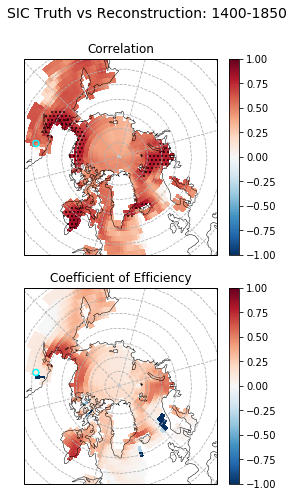

In [155]:
fig,ax = plt.subplots(2,1, figsize=(4, 7), subplot_kw = proj)
sub_arctic_plot(fig,ax[0],r_sic,ccsm4_truth_lat[:,0],ccsm4_truth_lon[0,:],'Correlation',1)
sub_arctic_plot(fig,ax[1],ce_sic,ccsm4_truth_lat[:,0],ccsm4_truth_lon[0,:],'Coefficient of Efficiency',1)
fig.suptitle('SIC Truth vs Reconstruction: 1400-1850', fontsize=14)
plt.tight_layout(rect=(0,0,1,0.93))
ax[0].scatter(ccsm4_truth_lon[0,lon_interest], ccsm4_truth_lat[lat_interest,0], facecolors='none',
              edgecolors='cyan', transform=ccrs.PlateCarree(), linewidth=1.5)
ax[1].scatter(ccsm4_truth_lon[0,lon_interest], ccsm4_truth_lat[lat_interest,0], facecolors='none',
              edgecolors='cyan', transform=ccrs.PlateCarree(), linewidth=1.5)

ax[0].contourf(ccsm4_truth_lon[0,:], ccsm4_truth_lat[:,0], sic_thresh, 
                  levels = [0,0.5,1],hatches=['','...'], alpha=0,
                  transform=ccrs.PlateCarree())
#plt.scatter(100, 10, color='m')

# savename = 'arctic_sic_gridcell_location_lat_'+str(lat_interest)+'_lon_'+str(lon_interest)+'.png'
# plt.savefig(savepath+savename)

In [156]:
r_pt,_,_ = kbstats.corr_timeseries(sic_truth_lalo[:,lat_interest,lon_interest],
                                   sic_lalo_ensmn[:,lat_interest,lon_interest])
ce_pt = kbstats.coefficient_efficiency(sic_truth_lalo[:,lat_interest,lon_interest],
                                       sic_lalo_ensmn[:,lat_interest,lon_interest])

In [157]:
print('Truth variance = ',str(np.round(np.var(sic_truth_lalo[:,lat_interest,lon_interest]),2)))
print('Recon variance = ',str(np.round(np.var(sic_lalo_ensmn[:,lat_interest,lon_interest]),2)))

Truth variance =  0.0
Recon variance =  0.0


In [158]:
min = sic_truth_lalo[:,lat_interest,lon_interest].min()
max = sic_truth_lalo[:,lat_interest,lon_interest].max()

In [159]:
np.var(sic_truth_lalo[:,lat_interest,lon_interest])

5.316930508700392e-07

In [160]:
print('CE = '+str(np.round(ce_pt,2))) 
print('Corr = '+str(np.round(r_pt,2)))
print('Var(truth) = '+str(np.var(sic_truth_lalo[:,lat_interest,lon_interest])))
print('Var(recon) = '+str(np.var(sic_lalo_ensmn[:,lat_interest,lon_interest])))
print('Mean(truth) = '+str(np.mean(sic_truth_lalo[:,lat_interest,lon_interest])))
print('Mean(recon) = '+str(np.mean(sic_lalo_ensmn[:,lat_interest,lon_interest])))

CE = 0.09
Corr = 0.48
Var(truth) = 5.316930508700392e-07
Var(recon) = 9.242177032630746e-09
Mean(truth) = 5.0664388538160306e-05
Mean(recon) = 0.0001607752344485072


(-0.0015, 0.0105)

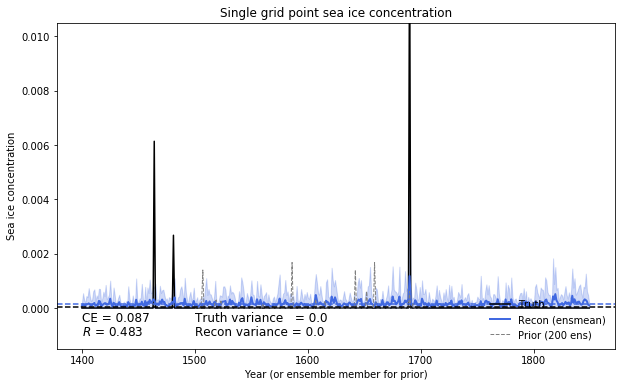

In [161]:
fig = plt.figure(figsize=(10,6))
plt.plot(recon_years, sic_truth_lalo[:,lat_interest,lon_interest], 
         color='k', label='Truth', linewidth=1.5)
plt.plot(recon_years, sic_lalo_ensmn[:,lat_interest,lon_interest], 
         color='royalblue', label='Recon (ensmean)', linewidth=2)
plt.fill_between(recon_years,sic_2_5_lalo[:,lat_interest,lon_interest],
                 sic_97_5_lalo[:,lat_interest,lon_interest],color='royalblue',alpha=0.25)
plt.plot(range(1500,1700),sic_prior_ensmn[:,lat_interest,lon_interest], 
         color='grey', label='Prior (200 ens)', linewidth=1, linestyle='--')

plt.axhline(np.nanmean(sic_truth_lalo[:,lat_interest,lon_interest],axis=0),
            color='k',linestyle='--')
plt.axhline(np.nanmean(sic_lalo_ensmn[:,lat_interest,lon_interest],axis=0),
            color='royalblue',linestyle='--')

text_locl = np.round(sic_truth_lalo[:,lat_interest,lon_interest].min(),2)
text_loch = np.round(sic_truth_lalo[:,lat_interest,lon_interest].max(),2)
text_diff = ((text_loch-text_locl)/10)*0.5

plt.text(1400,text_locl-2*text_diff,('$R$ = '+str(np.round(r_pt,3))),fontsize=12)
plt.text(1400,text_locl-text_diff,('CE = '+str(np.round(ce_pt,3))),fontsize=12)

plt.text(1500,text_locl-2*text_diff,('Recon variance = '+str(np.round(np.var(sic_lalo_ensmn[:,lat_interest,lon_interest]),2))),fontsize=12)
plt.text(1500,text_locl-text_diff,('Truth variance   = '+str(np.round(np.var(sic_truth_lalo[:,lat_interest,lon_interest]),2))),fontsize=12)

plt.legend(loc='lower right',frameon=False)
plt.ylabel('Sea ice concentration')
plt.xlabel('Year (or ensemble member for prior)')
plt.title('Single grid point sea ice concentration')

plt.ylim(text_locl-3*text_diff,text_loch+text_diff)
#plt.ylim(-0.0000001,0.00000025)
#plt.xlim(1400,1601)
#plt.ylim(88,101)